In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
import timeit

# Seed the random number generators for reproducibility
np.random.seed(100)

## Import smooth histograms and calculate time derivatives

In [52]:
filebase='data/ensemble/1'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H,dmax=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
t=np.arange(0,t1+dt,dt)
dat=np.transpose(np.load('data/ensemble/smoothhistograms.npy'),axes=(2,1,0))
nx,ny,nt=dat.shape
vmax=25
X, Y = np.meshgrid(np.arange(0,L,L/nx), np.arange(-vmax,vmax,2*vmax/ny))
spatial_grid = np.asarray([X, Y]).T


In [56]:
start=timeit.default_timer()
u=dat[:,:,:,np.newaxis]
u_dot = np.zeros((nx, ny, nt, 1))
print(u_dot.shape)
for i in range(nx):
    for j in range(ny):
        print(i,j,end='\r')
        u_dot[i, j, :, :] = ps.FiniteDifference()._differentiate(u[i, j, :, :], dt)
        
# Choose 60 % of data for training because data is big
train = np.random.choice(nt, int(nt * 0.6), replace=False)
test = [i for i in np.arange(nt) if i not in train]
u_train = u[:, :, train, :]
u_test = u[:, :, test, :]
u_dot_train = u_dot[:, :, train, :]
u_dot_test = u_dot[:, :, test, :]
t_train = t[train]
t_test = t[test]
spatial_grid = np.asarray([X, Y]).T

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (nx*ny * len(t_train), 1))
u_dot_train_flattened = np.reshape(u_dot_train, (nx*ny * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (nx*ny * len(t_test), 1))
u_dot_test_flattened = np.reshape(u_dot_test, (nx*ny * len(t_test), 1))

stop=timeit.default_timer()
print(stop-start)

(100, 100, 1001, 1)
4.6618471667170525


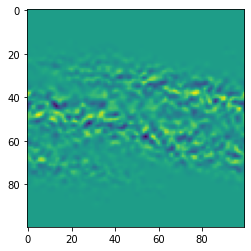

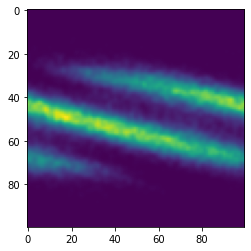

In [57]:
plt.imshow(u_dot[:,:,-1,0])
plt.show()
plt.imshow(u[:,:,-1,0])
plt.show()

In [62]:
library_functions = [lambda x: x, lambda x: x * x * x]
library_function_names = [lambda x: x, lambda x: x + x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid, include_bias=True, is_uniform=True)

optimizer = ps.STLSQ(threshold=1, alpha=1e-5, normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()
u_dot_stlsq = model.predict(u_test_flattened)

(x0)' = 0.001 1 + -0.001 x0 + 43.888 x0_11 + -0.744 x0_12 + 0.003 x0_22 + 0.011 x0x0_1 + -17.657 x0x0_11 + 0.029 x0x0x0x0_11 + 0.182 x0x0_12


## How to add the independent variable terms to the library functions??
## The library functions should take lists of independent and dependent variables to be general